In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from fittingmethods import RADEXFit, Pcube, MapData, PlotFittedMaps, CreateRadexGrids


/Users/mdance13/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Below we define a few basic parameters to use with our example data.

We define the molecular species and their transition numbers using the 'Mols' and 'js' list.
The list js is made up of the lower excitation level of the emission line.

The lines represented here are then 12CO(1-0), 13CO(1-0), 12CO(2-1), and 13CO(2-1), in that order.

We also include an 'Rindex' array indicating which lines share an abundance ratio. In this case, the 13CO lines should use an abundance ratio, and so both have designations of '1', and 12CO is the default abundance and the line that the output column densities are measured for, so they have a '0' in the Rindex array. The default behavior if Rindex is not specified is for each unique molecular species is given its own abundance ratio, and the first listed molecule is designated '0'. This parameter is intended to be used when fitting different molecules that contain the same isotope (such as 13C), and so can share an abundance ratio even though they are different molecules.

We then define a set of measured intensities (in brightness temperature units) and their respective errors to do preliminary fitting.

In [2]:
Mols = ['co', '13co', 'co', '13co']
js = [0,0,1,1]
Rindex = [0,1,0,1]

Imax = np.array([1.51, 0.41, 2.12, 0.39])
delts = np.array([0.11, 0.008, 0.1, 0.04])

# Creating RADEX model grids

The cell below can be used to generate pre-computed RADEX model grids for sets of temperatures, H2 densities, and column densities. This is the exact call used to build the co.examplegrid.pkl and 13co.examplegrid.pkl grids that are available to be downloaded with this notebook. 

Running this code can take several minutes, and so we recommend isntead using the downloaded example grids unless you would like to test different parameter ranges. H2 density and column density arrays (narr and Narr) should always be in log scale.

Grids used in the fitting methods should all have the same temperature and density ranges (Tarr and narr), but can have different column ranges (Narr) to better represent typical abundance ratios. Column density arrays should all have the same spacing (i.e. 0.1 in this case) and be separated by an integer multiple of that spacing. If you would like all grids to share the same parameter ranges, you can instead pass a list of molecules to one call of the CreateRadexGrids function.

The linewidth (dv) used in the creation of the grids should match the channel size of the observations being fit. At the moment, only a single linewidth is supported in the fitting.

These grids include emission lines with frequencies up to 500 GHz, so include lines up to 12CO(4-3) and 13CO(4-3). The freqmin and freqmax parameters can be used to expand to higher transitions. We do not recommend increasing frequmin, but do leave the option to not include the lowest transition lines. If the lowest transition level (1-0) is not included, the 'js' input above needs to be adjusted so that a value of 0 corresponds to the lowest energy transition included.



In [3]:
#Tarr = np.arange(5,51,1.)
#narr = np.arange(2,5.1,0.1)
#Narr = np.arange(15, 17.5,0.1)
#dv = 1.
#CreateRadexGrids('examplegrid', ['co'], Tarr, narr, Narr, dv, nprocs=4)

# Update column range for 13CO and run again
#Narr = np.arange(13, 15.5,0.1)
#CreateRadexGrids('examplegrid', ['13co'], Tarr, narr, Narr, dv, nprocs=4)


# Basic Fitting Functions

Below we attempt our first basic fit of data with all default parameters. 

We create a RADEX fitting object, then run the 'fit' method on a set of data points and their error to create a Pcube object ('PC') with the probability distribution. We then use the Pcube methods printstats() and plot() print the output statistics and create a corner plot of the probability distribution.

By default the co.examplegrids.pkl and 13co.examplegrids.pkl files are loaded. If you would like to use other grids, input the suffix of the filenames ('examplegrids.pkl') using the 'radexgridfile' parameter. The object will then append each molecule name from the Mols parameter ('co.' and '13co.') to the provided file name to load.

Loading pickle files 2023-08-22 13:59:27.208579
Done loading pickle files 2023-08-22 13:59:27.215439

Using R =  100

T_kin  =  5.0
Uncertainty Range:  [5.0, 5.0]
log_n  =  5.0
Uncertainty Range:  [4.6, 5.0]
log_N  =  16.8
Uncertainty Range:  [16.8, 16.8]


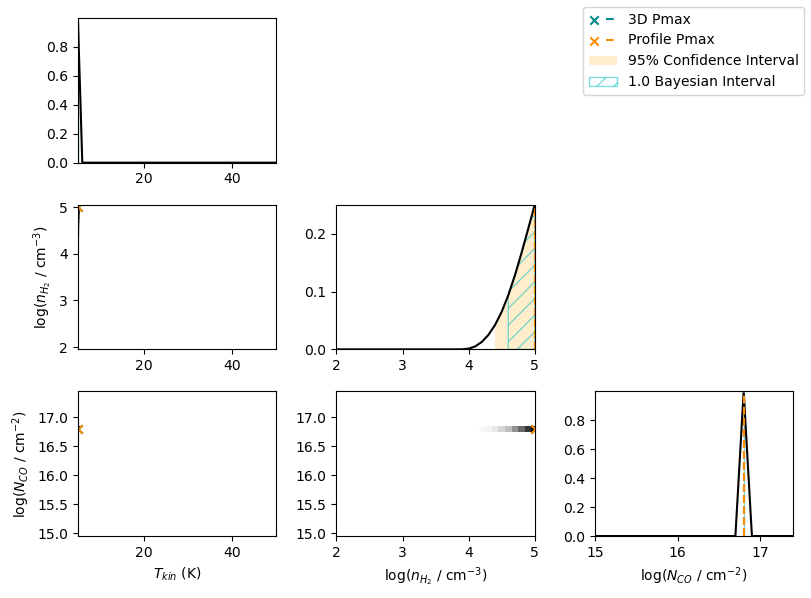

In [4]:
rfit = RADEXFit(Mols, js)

PC = rfit.fit(Imax, delts)

PC.printstats()
PC.plot()

Notice the fit above is not particularly good, as evidenced by the probability distribution peak values falling on the very edges of the range for T and n. This is because a beam filling factor is needed to fit the data well.

We fit the data again below, this time using an assumed filling factor of 0.25. This results in a much better fit.

We also test inputting a different abundance ratio value (Rvals) than the default value of 100. Abundance ratios are implemented by offsetting the column density grids of different molecular species by an integer number of indices. For example, fitting with a 12CO/13CO ratio of 100 is implemented by offsetting the pre-computed model grids for 12CO and 13CO in the column dimension by 20 indices since the indices have a size of 0.1 in log scaling. Since the offset must be an integer multiple of 0.1 dex, there are a limited set of acceptable abundance ratios. Below we request an abundance ratio of 80, so the fitting uses the closest allowable ratio of 79 instead.

Also notice that rather than load the grids again, we can pass the grids from the previous instance of 'rfit' here with the 'radexgrids' parameter. 

Using R =  79

T_kin  =  12.0
Uncertainty Range:  [12.0, 12.0]
log_n  =  3.7
Uncertainty Range:  [3.6, 3.8]
log_N  =  17.1
Uncertainty Range:  [17.1, 17.1]


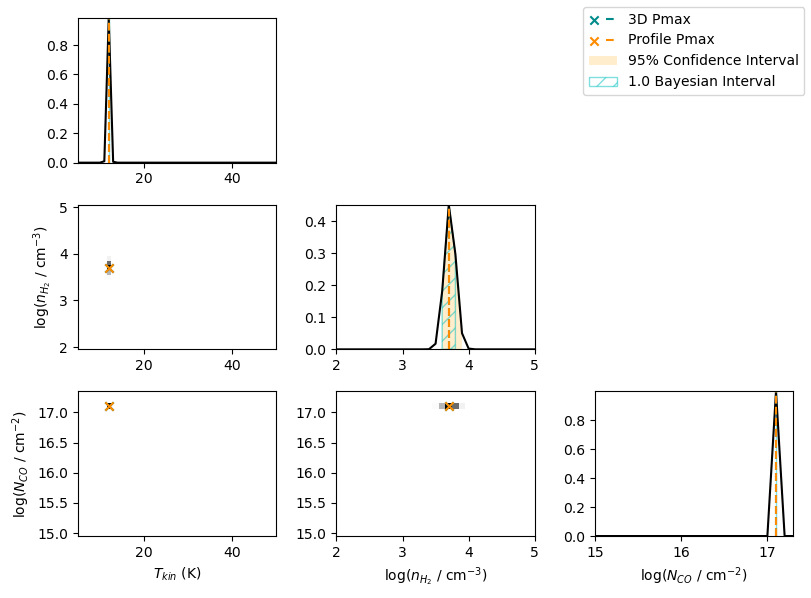

In [5]:
rfit = RADEXFit(Mols, js, bff=0.25, Rvals=80., radexgrids=rfit.radexgrids)

PC = rfit.fit(Imax, delts)

PC.printstats()
PC.plot()

We can also add other parameters to the fitting by using the 'mode' parameter when initializing the RADEXFit object.

Below, we fit the best filling factor for the data points above using the mode 'fitbff'.

Instead of passing a value to bff, we instead pass a range to 'bffarr', which is the range of filling factors that will be fit. The default range if none is given is from 0.05 to 1.0 in intervals of 0.05. We use a smaller range here to speed up computation.

Using R =  100

T_kin  =  14.0
Uncertainty Range:  [14.0, 14.0]
log_n  =  3.6
Uncertainty Range:  [3.5, 3.7]
log_N  =  17.3
Uncertainty Range:  [17.3, 17.3]
ff  =  0.2
Uncertainty Range:  [0.2, 0.2]


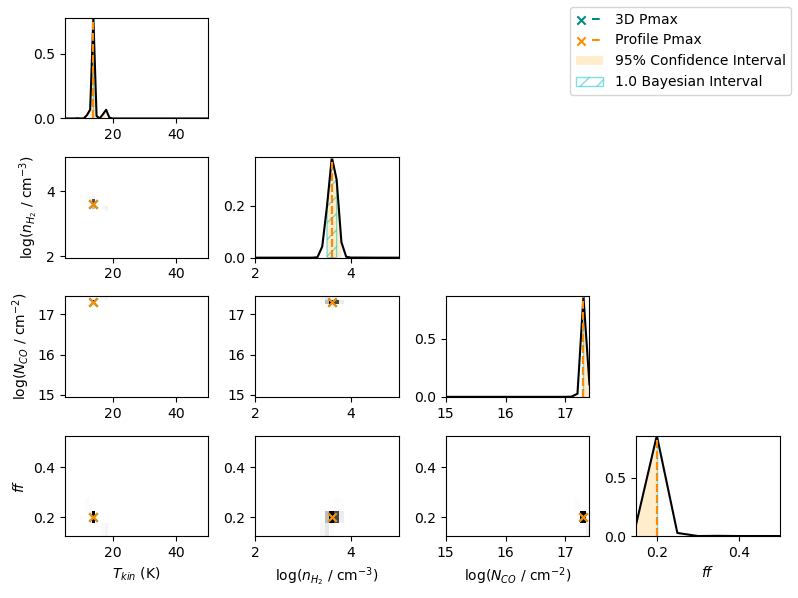

In [6]:
rfitbff = RADEXFit(Mols, js, mode='fitbff', radexgrids=rfit.radexgrids, bffarr=np.arange(0.15, 0.55, 0.05))

PC = rfitbff.fit(Imax, delts)

PC.printstats()
PC.plot()

Another option is to fit the abundance ratio using the mode 'fitratio'. 

In this case, we use the 'Bounds' parameter to input a dictionary with the range of abundance ratios to consider. The dictionary key for the first abundance ratio is 'R1', and other accepted keys include 'T', 'n', and 'N' to limit the fitted ranges of temperature, density, and column. 

It is also possible to fit multiple abundance ratios by having more than two unique molecular species in the 'Mols' list or by inputting an Rindex parameter. In this case, the ranges of those abundance ratios can be specified with Bounds using keys of 'R1', 'R2', 'R3', and so on. The number after 'R' is based on the listed order the molecules with different abundances or the value in Rindex if given.

We also input an assumed filling factor again.

T_kin  =  12.0
Uncertainty Range:  [12.0, 12.0]
log_n  =  3.7
Uncertainty Range:  [3.6, 3.8]
log_N  =  17.1
Uncertainty Range:  [16.9, 17.1]
R1  =  79.43
Uncertainty Range:  [50.12, 79.43]


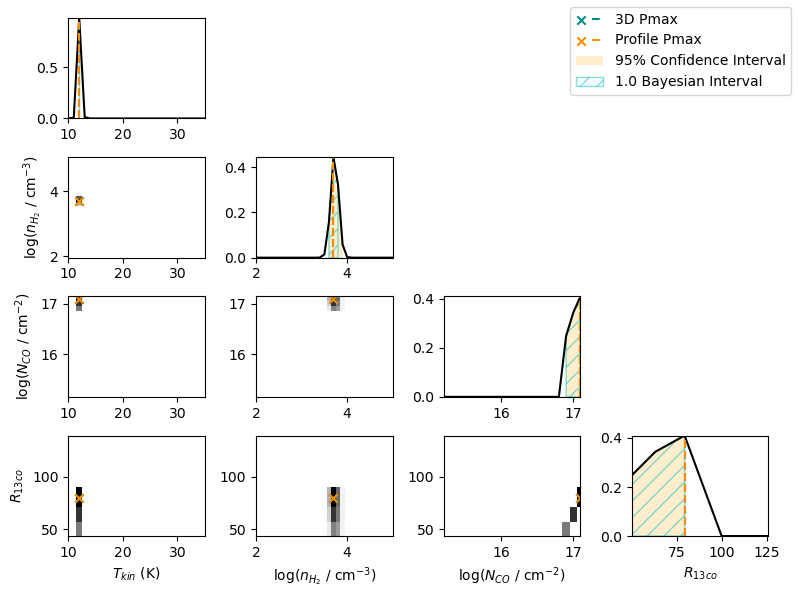

In [7]:
rfitratio = RADEXFit(Mols, js, mode='fitratio', radexgrids=rfit.radexgrids, 
                     Bounds={'R1':[50,150], 'T':[10,35]}, bff=0.25)

PC = rfitratio.fit(Imax, delts)

PC.printstats()
PC.plot()

You can also fit both the filling factor and abundance ratios at once. 

The quality and reliability of the fitting does, however, decrease as more fitted parameters are added. We recommend having more emission line data points than fitted parameters. In this example case, we have 4 measured lines, and so best practice would be to fit neither the filling factor nor the abundance ratio.

T_kin  =  14.0
Uncertainty Range:  [14.0, 14.0]
log_n  =  3.6
Uncertainty Range:  [3.6, 3.7]
log_N  =  17.1
Uncertainty Range:  [17.0, 17.1]
ff  =  0.2
Uncertainty Range:  [0.2, 0.2]
R1  =  63.1
Uncertainty Range:  [50.12, 63.1]


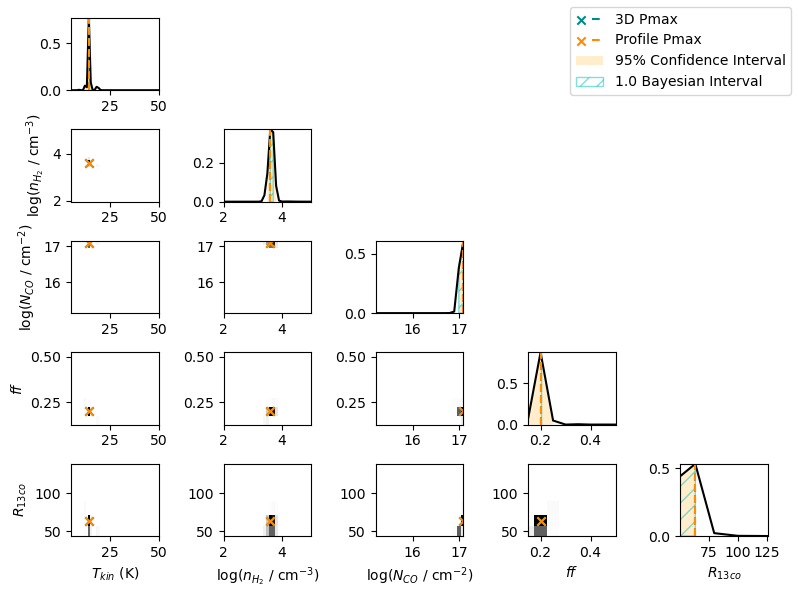

In [8]:
rfitbffratio = RADEXFit(Mols, js, mode='fitbffratio', radexgrids=rfit.radexgrids, 
                     Bounds={'R1':[50,150]}, bffarr=np.arange(0.15, 0.55, 0.05))

PC = rfitbffratio.fit(Imax, delts)

PC.printstats()
PC.plot()

To avoid any dependence on filling factor, it is also possible to perform the fitting with only the intensity ratios of the emission lines rather than their absolute values. To do this, use the mode 'fitTBratio'.

For this mode, one of the molecules will be used as the denominator of these intensity ratios. The default is that the first molecule (index=0) will be used. To change this, we can use the 'denomi' to give a different index. Below we choose to use 13CO(1-0) as the denominator by passing denomi=1.

Using R =  100

T_kin  =  16.0
Uncertainty Range:  [15.0, 16.0]
log_n  =  3.6
Uncertainty Range:  [3.5, 3.7]
log_N  =  17.4
Uncertainty Range:  [17.4, 17.4]


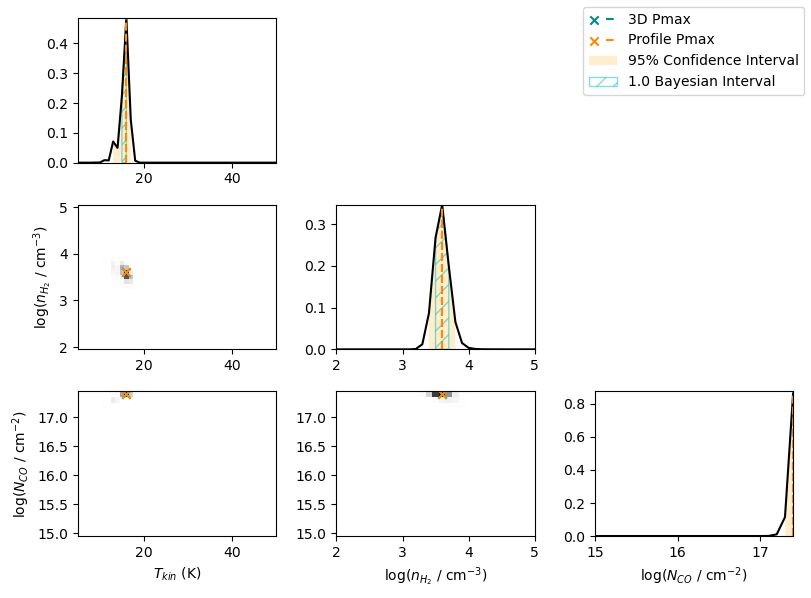

In [9]:
rfitTBratio = RADEXFit(Mols, js, mode='fitTBratio', radexgrids=rfit.radexgrids, denomi=1)

PC = rfitTBratio.fit(Imax, delts)

PC.printstats()
PC.plot()


When plotting a fitted probability cube, there are a few other options as well.

You can switch the scaling to 'log' instead of 'linear' to better see the details of the fitting.

You can add a title to the plot.

You can list which statistical intervals you want to be plotted. The options for this include the 95% confidence interval, 67% confidence interval, 5.0 Bayesian interval, 2.5 Bayesian interval, and 1.0 Bayesian interval using either the strings 'CI95', 'CI67', 'BI5', 'BI2.5', or 'BI1', or the integers 1, 2, 3, 4, 5, respectively, to refer to those intervals.

You can also plot the locations of the LTE-derived temperature and column density. Or if you are fitting simulated observations where the "true" value is known, you can plot the locations of those model values. 

You can also save the plot to disk insted of showing it with the 'save' parameter. In this case, you can provide a file name and preferrred file format.

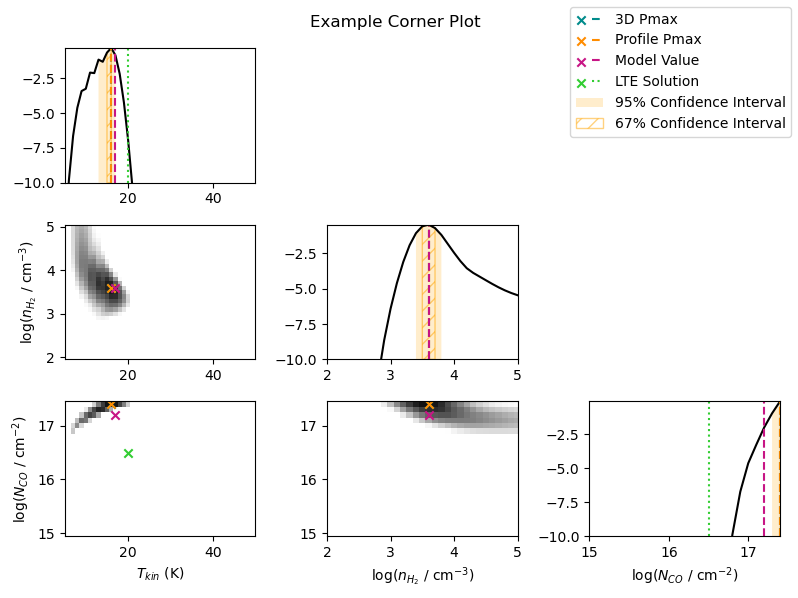

In [10]:
PC.plot(scale='log', plotintervals=['CI95', 2], LTE=[20., 16.5], model=[17,3.6,17.2], title='Example Corner Plot')

# Loading Data

Now we test out uploading full data cubes from fits files using the MapData object.

We initiate the object by giving identifiers about what emission line the files correspond to with 'Mols' and 'js', and a list of file locations. 

You can also limit the RA, Dec, and velocity ranges included using pixel and/or channel values with 'ralim', 'declim', and 'vellim'. 

By default the error will be calculated from these maps using a robust median absolute deviation, but you can also pass your own calculation of the error if you prefer. 

If the data is not already in brightness temperature units, it is automatically converted assuming that the data is instead in Jy/beam units. 

All data cubes are also expected to have the same beam sizes, shapes, pixel sizes, and channel sizes. If they do not, a warning will be printed but the data loading will not fail unless the data shapes are different.

In [11]:
# Load in data
dat = MapData(Mols, js, ['../Ridge_MAGMATP_12CO10.fits','../Ridge_13CO10.mTfT.pbcor.smooth45rg.fits', '../Ridge_APEXTP_12CO21.smooth45.fits', '../RidgeMap_13CO21.im3.smooth.fits'])

# Print the calculated error for each line
print()
print(dat.error)

Converting  13co 0  from Jy/beam to brightness temperature

[0.11483476569785366, 0.007997029474708874, 0.1084693767247097, 0.040388532162083414]


We also upload a clump assignment file. This clump file was generated with quickclump (Sidorin 2017). 

Any clump assignment cube will work as long as it: 

1) is the same shape as the data cubes

2) uses integers as voxel values to denote which clump the voxel belongs to

3) a value of 0 indicates the voxel does not belong to a clump

In [12]:
Clumps = fits.getdata('../Ridge_13CO10.mTfT.pbcor.smooth45rg.clumps.fits')

# Fitting a List

If we are interested in fitting several data points, but not the whole map, we can pass a list of data points to the RADEXFit.fitlist() method. This will return a list of fitting results, as well as saving those results to a table if requested.

The table includes the best-fit value of a parameter, then the lower and upper bounds of the uncertainty range, repeated for each fitted parameter. 

By default it uses the "preferred" uncertainty range, which is the better constrained of the 95% confidence interval and 1.0 Bayesian interval (see Finn e5.0 t al. 2021 for a detailed description of these). To override that preferred range, you can instead use the 'interval' parameter to request a specific statistical interval be output. The options for this include the 95% confidence interval, 67% confidence interval, 5.0 Bayesian interval, 2.5 Bayesian interval, and 1.0 Bayesian interval using either the strings 'CI95', 'CI67', 'BI5', 'BI2.5', or 'BI1', or the integers 1, 2, 3, 4, 5, respectively, to refer to those intervals.

In [13]:
# First create a list of data points, taken from the peak value in each clump
IntList = []

for ncl in np.unique(Clumps):
    # Mask clump
    Data = np.where(Clumps==ncl, dat.data, np.nan)
    # Use the 12CO(1-0) line to determine peak location in clump
    argmax = np.unravel_index(np.nanargmax(Data[0]), Data[0].shape)
    
    # Append data from all lines in peak voxel
    IntList.append(Data[:,argmax[0],argmax[1],argmax[2]])
    
IntList = np.array(IntList)

In [14]:
# Fit each data point and save to the given file name
ResList = rfit.fitlist(IntList, dat.error, save=True, fname='ClumpPeakFits.dat')

In [15]:
# Return only the 95% confidence intervals instead
ResList_CI95 = rfit.fitlist(IntList, dat.error, save=True, fname='ClumpPeakFits_CI95.dat', interval='CI95')

# Fitting a Map

The primary purpose of this code is to fit a set of data cubes to create maps of physical conditions. We do this with the RADEXFit.fitmap() method. It intakes a MapData object like the one we made above.

Below, we show examples for fitting the full map with no masks or clump assignments, fitting with a manually made mask, and fitting with a clump assignment cube.

The default version fits the line peak of each pixel first, then holds all parameters except the column density fixed to the uncertainty ranges of the peak pixel. This avoids unwanted behavior in the line wings where detections are weaker. To fit each velocity channel independently, pass 'linefixed=False'. 

The default version of the fitting determines where lines are detected in a pixel based on a 5sigma threshold, and requires that to fit a pixel, there must be detections a certain number of the lines. This number is the smaller of one less than the number of parameters being fit or the total number of lines observed. Both of these defaults can be changed using the sigma_threshold and line_threshold parameters. 

By default, the code willl also save the fitting output of each clump's fit unless the 'save' parameter is set to False. We have set it to False here. 

It is also possible to plot and save the resulting fit of each fitted peak or of every single fit (with 'plotpeak' and 'plotall' parameters). This creates a very large number of plots, and is only recommended for testing purposes with small samples of the map. Similarly, the full probability cube object can also be saved for every fit with the parameter 'savePC'. 

To perform these fits with parallel processing, pass a number of processors ('nprocs'). If 'nprocs' is not passed, no parallel processing is performed. 

Done computing fits!


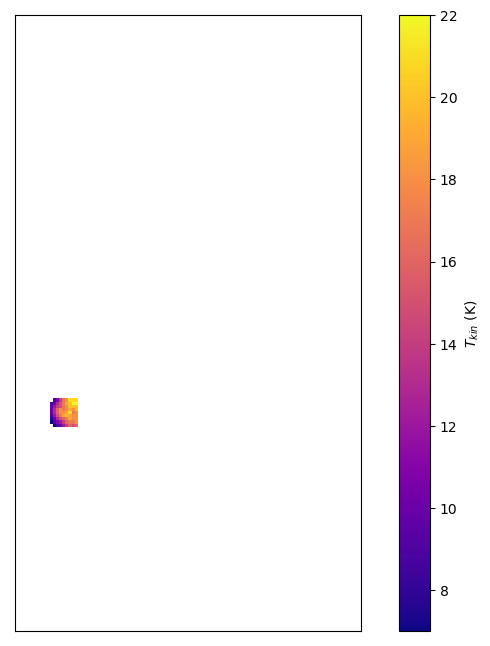

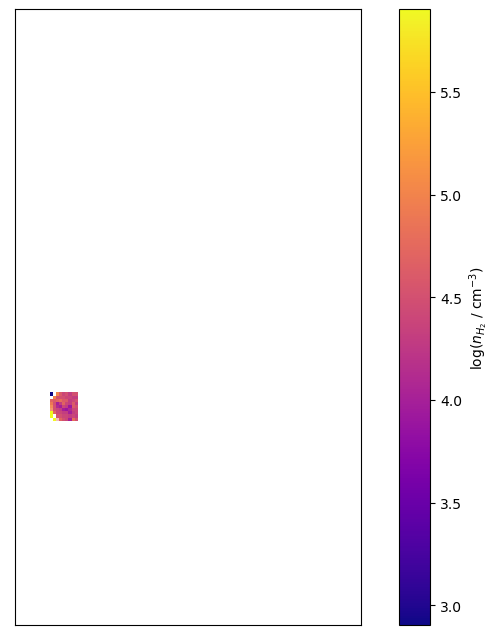

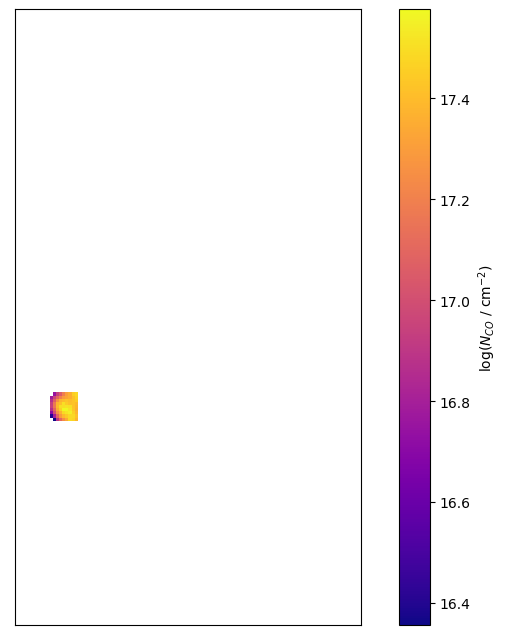

In [16]:
# Manually create a mask of zeros and ones (or bools) to apply in the fitting
mask = np.zeros(dat.dshape[2:])
mask[65:74,11:20] = 1
# Also can manually create a clump mask by using integers above 1 as clump identifiers
#mask[37:46,23:32] = 2

# Run the clump fitting with 3 parallel processors
resarray = rfit.fitmap(dat, save=False, ClumpMask=mask, nprocs=3)

# Fit the output map
PlotFittedMaps(rfit.plotparams, resarray, ploterror=False)

Done computing fits for clump 5
Done computing fits for clump 8


/Users/mdance13/Documents/UVA/Research/RadexFitting/RadexFittingCode/fittingmethods.py:1080: RuntimeWarning: All-NaN slice encountered
  mom8s = np.nanmax(MapData.data, axis=1)
/Users/mdance13/Documents/UVA/Research/RadexFitting/RadexFittingCode/fittingmethods.py:1084: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(obsfootprint, [0.5], linewidth=0.5, colors='k', linestyles='--', alpha=0.5)


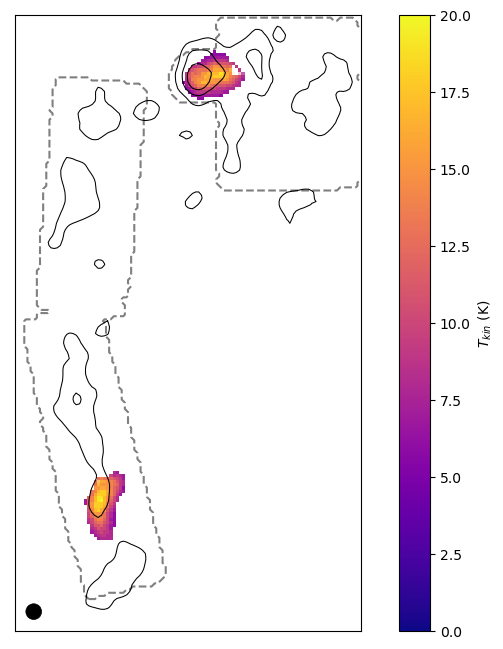

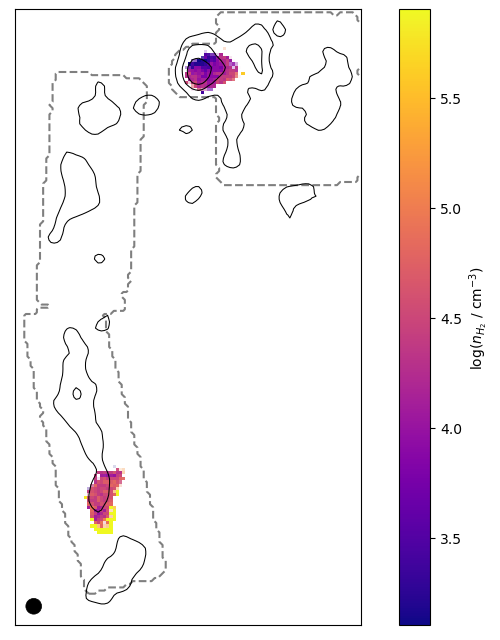

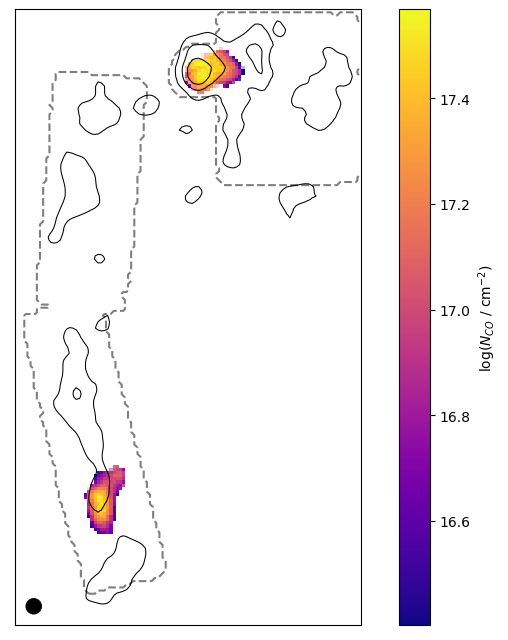

In [17]:
# Instead of making a manual mask, pass the clump assignment cube that we loaded
# Can request that only two clumps get fitted and then plotted
resarray = rfit.fitmap(dat, save=False, ClumpMask=Clumps, clumparray=[5,8], nprocs=3)

# This time when plotting, add in MapData to plot contours, beam, and observation footprint!
PlotFittedMaps(rfit.plotparams, resarray, ploterror=False, MapData=dat)

Done computing fits for clump 5
Done computing fits for clump 8


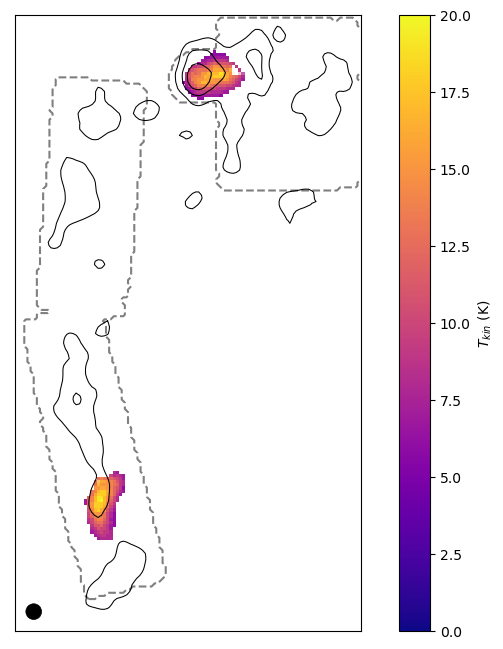

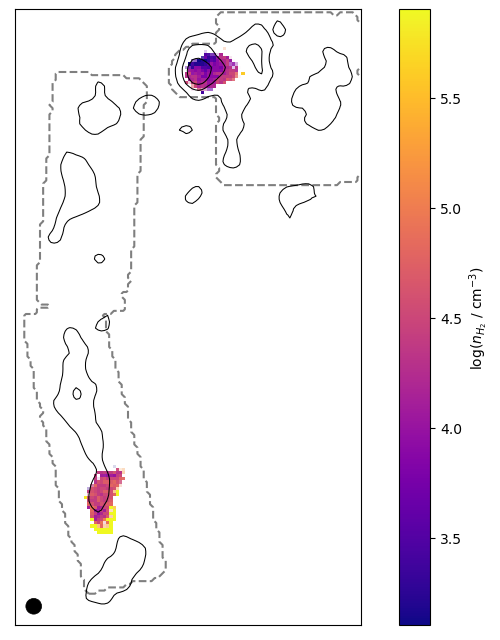

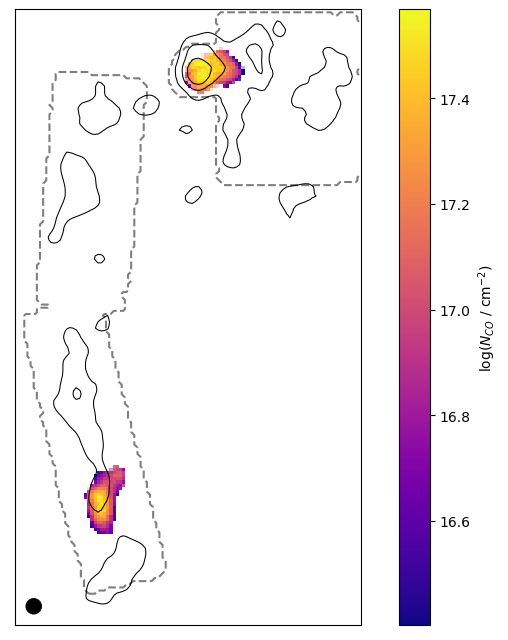

In [18]:
# Can also save the results to pickle files on disk
resarray = rfit.fitmap(dat, save=True, ClumpMask=Clumps, clumparray=[5,8], nprocs=3, fname='ExampleFits')

# To plot these results, pass the same root filename used when saving instead of the resarray parameter
# In this case, we need to tell the function which clump identifiers to 
#   look for in the file name with clumparray
PlotFittedMaps(rfit.plotparams, resarray='ExampleFits', clumparray=[5,8], ploterror=False, MapData=dat)

Done computing fits for clump 5
Done computing fits for clump 8


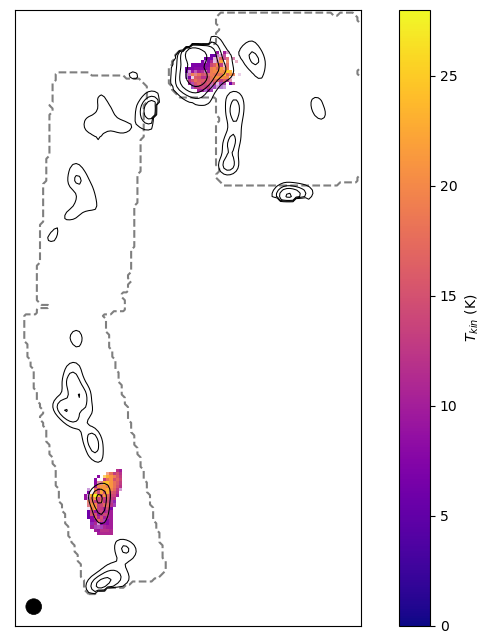

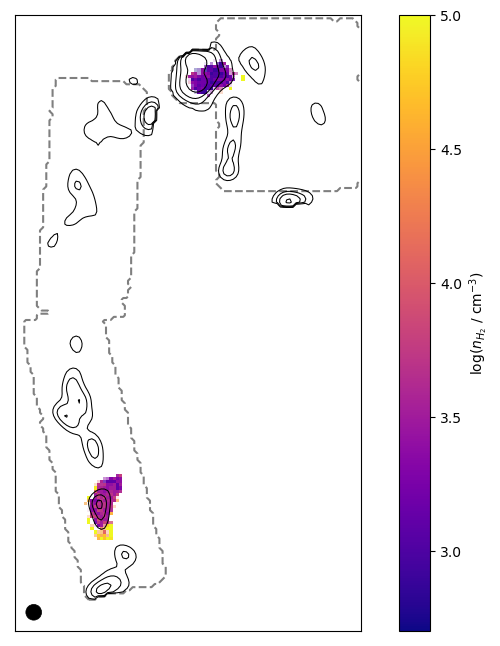

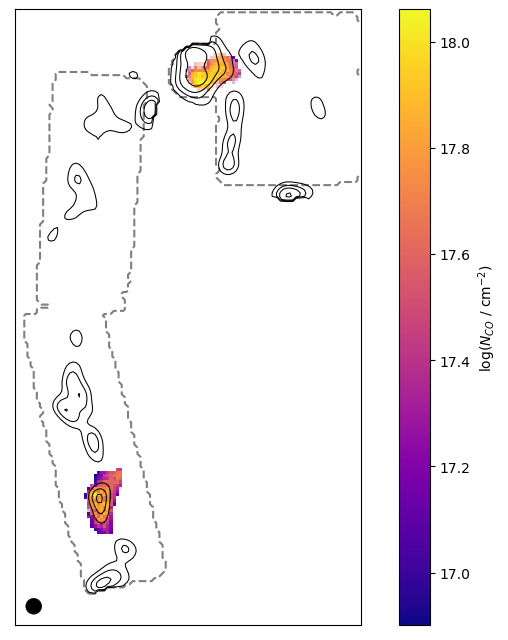

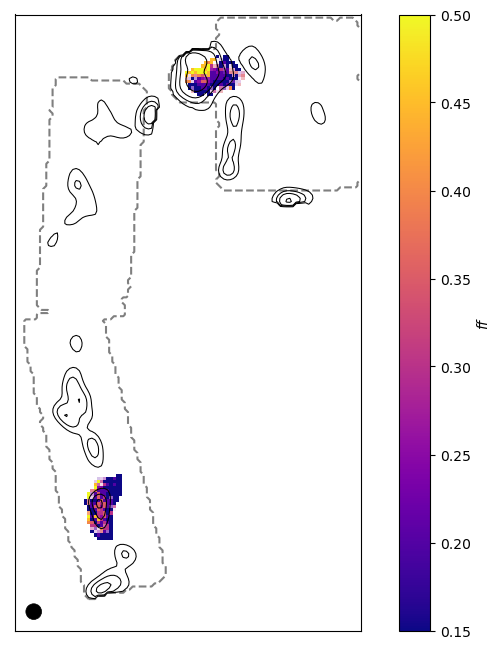

In [22]:
# We can of course also do all this fitting with RADEXFit objects that use different fitting
# modes, such as here where we include filling factor fitting
# The more fitted parameters, the longer the fitting takes.
resarray = rfitbff.fitmap(dat, save=False, ClumpMask=Clumps, clumparray=[5,8], nprocs=3)

# You can change which map's contours get plotted, here we switch to plotting the map with
# index 1 in the data object, which is 13CO(1-0)
# You can also change which contours get plotted, where the input list is fractions of the peak value
PlotFittedMaps(rfitbff.plotparams, resarray, ploterror=False, MapData=dat, 
               contourmap=1, contours=np.array([0.2,0.35,0.5,0.75]))

Done computing fits for clump 1
Done computing fits for clump 2
Done computing fits for clump 3
Done computing fits for clump 4
Done computing fits for clump 5
Done computing fits for clump 6
Done computing fits for clump 7
Done computing fits for clump 8
Done computing fits for clump 9
Done computing fits for clump 10
Done computing fits for clump 11
Done computing fits for clump 12
Done computing fits for clump 13
Done computing fits for clump 14
Done computing fits for clump 15
Done computing fits for clump 16
Done computing fits for clump 17
Done computing fits for clump 18
Done computing fits for clump 19
Done computing fits for clump 20
Done computing fits for clump 21
Done computing fits for clump 22
Done computing fits for clump 23
Done computing fits for clump 24
Done computing fits for clump 25
Done computing fits for clump 26
Done computing fits for clump 27
Done computing fits for clump 28
Done computing fits for clump 29
Done computing fits for clump 30
Done computing fits

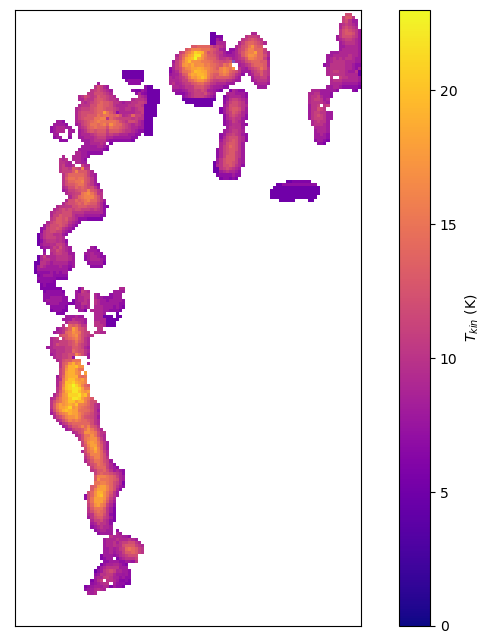

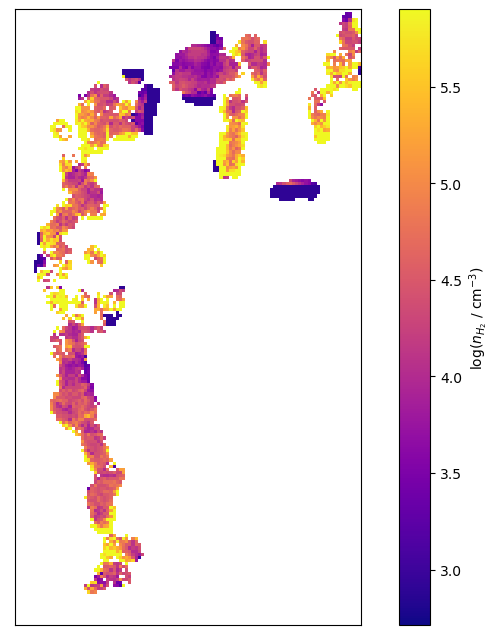

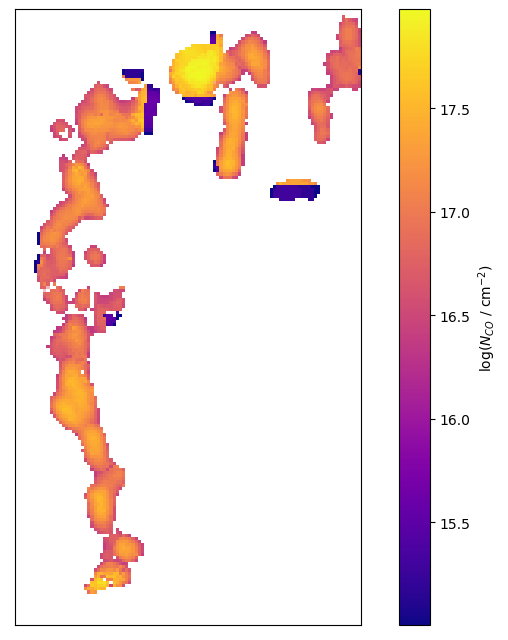

In [20]:
# To run all clumps in a clump assignment cube, simply remove the clumparray parameter
# Running the code below takes ~half a minute, more or less depending on number of parallel processors
resarray = rfit.fitmap(dat, save=False, ClumpMask=Clumps, nprocs=3)

PlotFittedMaps(rfit.plotparams, resarray, ploterror=False, MapData=dat)

Done computing fits!


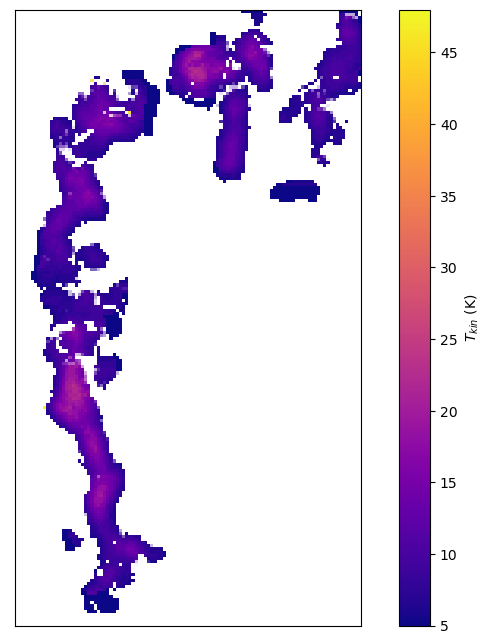

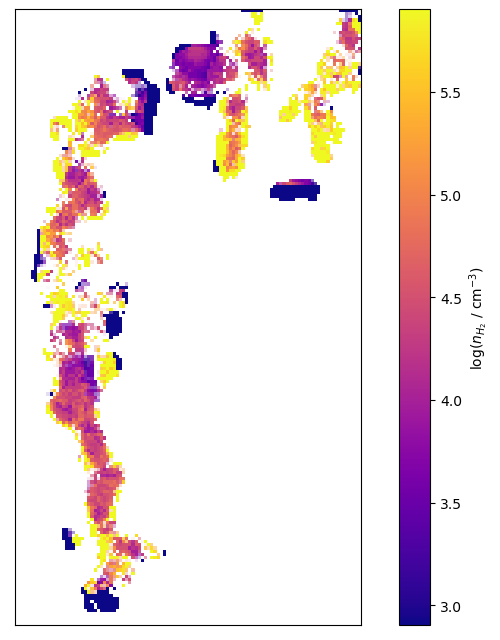

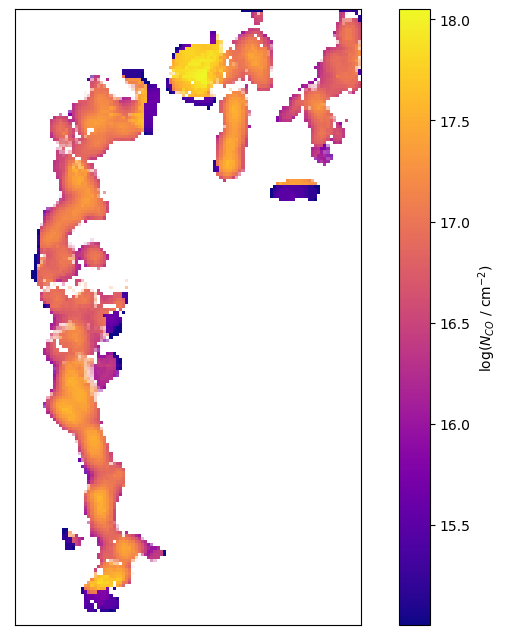

In [21]:
# Here we run the fitting on the whole map with no clumps identified.
# More of the pixels are included because of this, but most of the 
#   additional pixels have weak detections and poor fits anyways
resarray = rfit.fitmap(dat, save=False, nprocs=3)

PlotFittedMaps(rfit.plotparams, resarray, ploterror=False, MapData=dat)

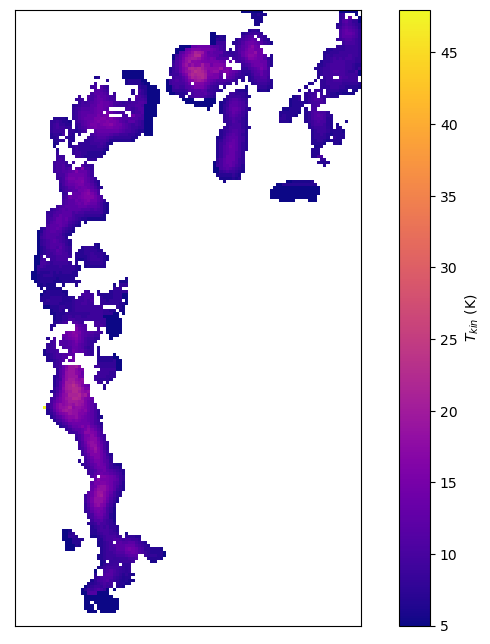

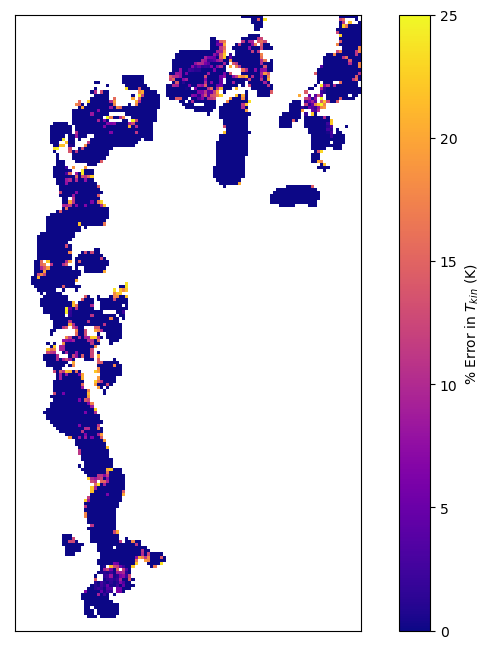

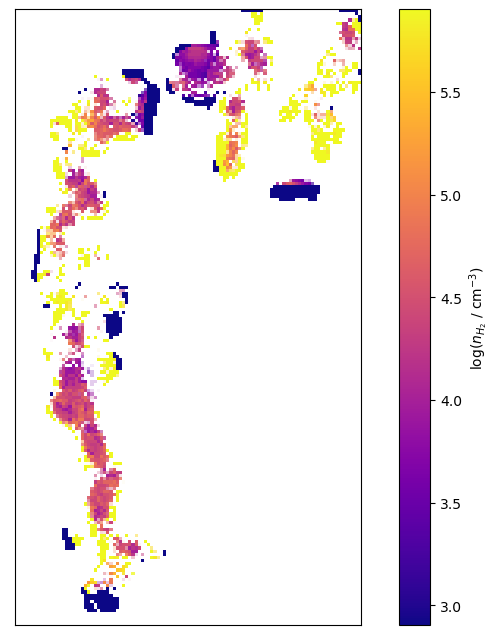

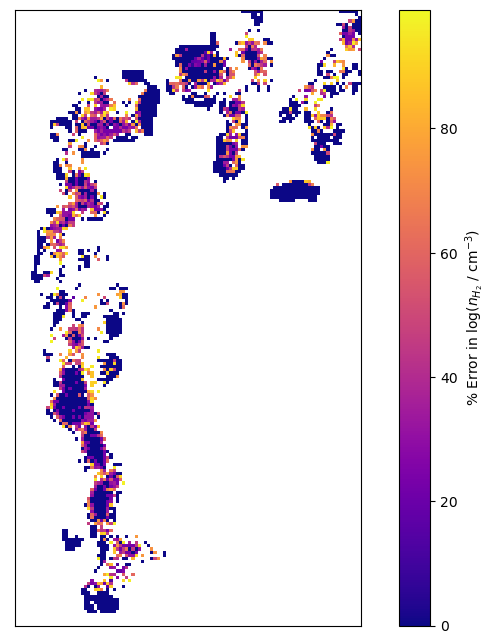

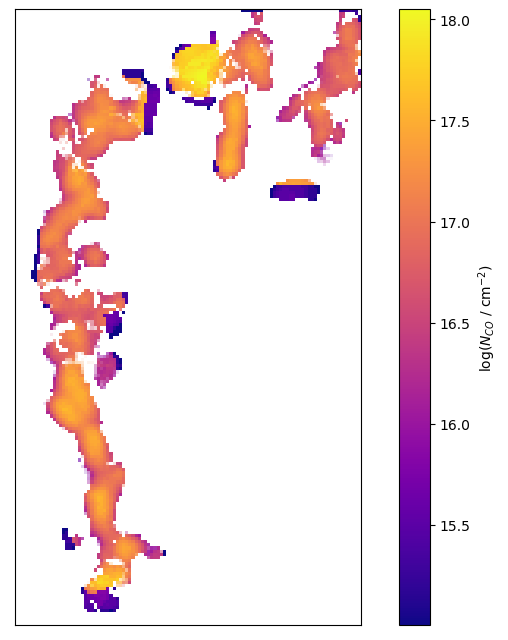

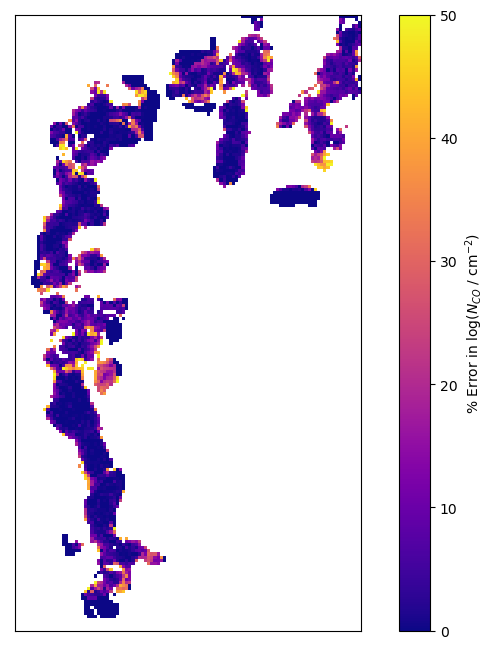

In [22]:
# To try to remove some of the poor fits, we can lower the error thresholds.
# By default, PlotFittedMaps masks results that have larger than 50% error in T, 
#   200% error in n, and 80% error in N. 

PlotFittedMaps(rfit.plotparams, resarray, ploterror=True, errorthresholds=[0.25,1.,0.5], MapData=dat)

# Fitting from Finn et al. (2021)

Below is a close approximation to how this code was implemented in Finn et al. (2021).

Rather than fit the filling factor or the abundance ratio, we calculated best estimates for the filling factor of approximately 15% and used two abundance ratios, which we then averaged the results of in the final maps. 

This is not exactly the same since the pre-computed RADEX grids used here are much courser. Running the fitting with the full-sized grids requires more RAM than is available on most laptops.

Additionally, the final map plotting in Finn+21 involved a more nuanced handling of which results we considered unreliable. This included removing extremely large or small best-fit parameters and a more careful handling of which clumps should be included.

In [23]:
bff=0.15

rfit1 = RADEXFit(Mols, js, bff=bff, Rvals=[100], radexgrids=rfit.radexgrids)
rfit2 = RADEXFit(Mols, js, bff=bff, Rvals=[50], radexgrids=rfit.radexgrids)

resarray1 = rfit1.fitmap(dat, save=False, ClumpMask=Clumps, nprocs=4)
resarray2 = rfit2.fitmap(dat, save=False, ClumpMask=Clumps, nprocs=4)

Using R =  100

Using R =  50

Done computing fits for clump 1
Done computing fits for clump 2
Done computing fits for clump 3
Done computing fits for clump 4
Done computing fits for clump 5
Done computing fits for clump 6
Done computing fits for clump 7
Done computing fits for clump 8
Done computing fits for clump 9
Done computing fits for clump 10
Done computing fits for clump 11
Done computing fits for clump 12
Done computing fits for clump 13
Done computing fits for clump 14
Done computing fits for clump 15
Done computing fits for clump 16
Done computing fits for clump 17
Done computing fits for clump 18
Done computing fits for clump 19
Done computing fits for clump 20
Done computing fits for clump 21
Done computing fits for clump 22
Done computing fits for clump 23
Done computing fits for clump 24
Done computing fits for clump 25
Done computing fits for clump 26
Done computing fits for clump 27
Done computing fits for clump 28
Done computing fits for clump 29
Done computing fits f

In [24]:
# Take the mean value of the best-fit parameter
resarrayFinal = np.nanmean([resarray1, resarray2], axis=0)
# Take the lowest of the lower uncertainty range
resarrayFinal[:,1::3] = np.nanmin([resarray1[:,1::3], resarray2[:,1::3]], axis=0)
# Take the highest of the upper uncertainty range
resarrayFinal[:,2::3] = np.nanmax([resarray1[:,2::3], resarray2[:,2::3]], axis=0)

/var/folders/ft/4tf9cgf53tj5368xmmc1yyn80000gn/T/ipykernel_59986/1045663786.py:2: RuntimeWarning: Mean of empty slice
  resarrayFinal = np.nanmean([resarray1, resarray2], axis=0)
/var/folders/ft/4tf9cgf53tj5368xmmc1yyn80000gn/T/ipykernel_59986/1045663786.py:4: RuntimeWarning: All-NaN axis encountered
  resarrayFinal[:,1::3] = np.nanmin([resarray1[:,1::3], resarray2[:,1::3]], axis=0)
/var/folders/ft/4tf9cgf53tj5368xmmc1yyn80000gn/T/ipykernel_59986/1045663786.py:6: RuntimeWarning: All-NaN axis encountered
  resarrayFinal[:,2::3] = np.nanmax([resarray1[:,2::3], resarray2[:,2::3]], axis=0)


/Users/mdance13/Documents/UVA/Research/RadexFitting/RadexFittingCode/fittingmethods.py:1080: RuntimeWarning: All-NaN slice encountered
  mom8s = np.nanmax(MapData.data, axis=1)
/Users/mdance13/Documents/UVA/Research/RadexFitting/RadexFittingCode/fittingmethods.py:1084: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(obsfootprint, [0.5], linewidth=0.5, colors='k', linestyles='--', alpha=0.5)


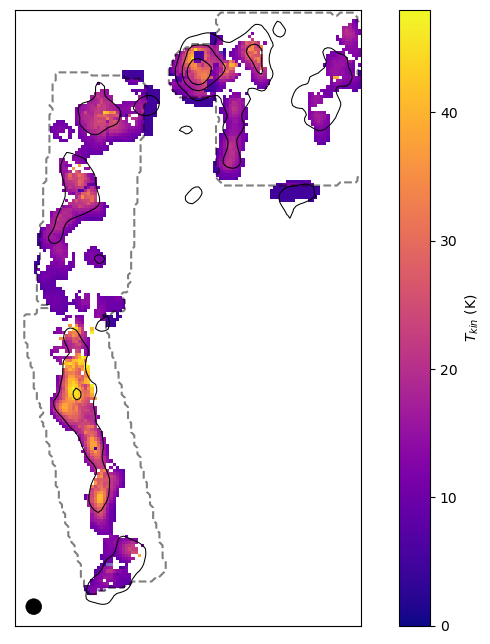

/Users/mdance13/Documents/UVA/Research/RadexFitting/RadexFittingCode/fittingmethods.py:1130: RuntimeWarning: All-NaN slice encountered
  mom8s = np.nanmax(MapData.data, axis=1)
/Users/mdance13/Documents/UVA/Research/RadexFitting/RadexFittingCode/fittingmethods.py:1133: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(obsfootprint, [0.5], linewidth=0.5, colors='k', linestyles='--', alpha=0.5)


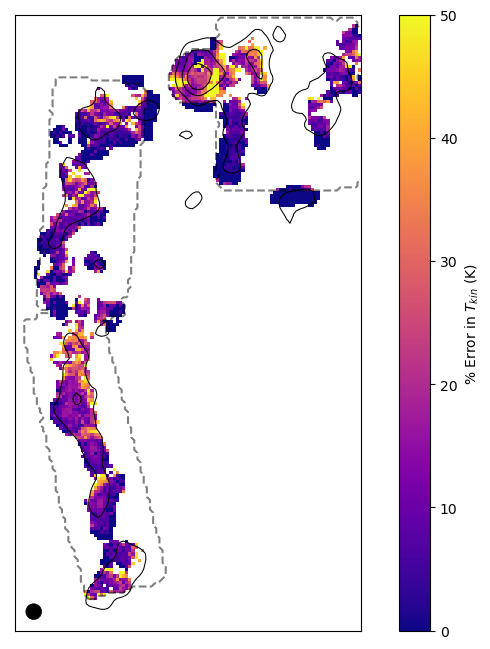

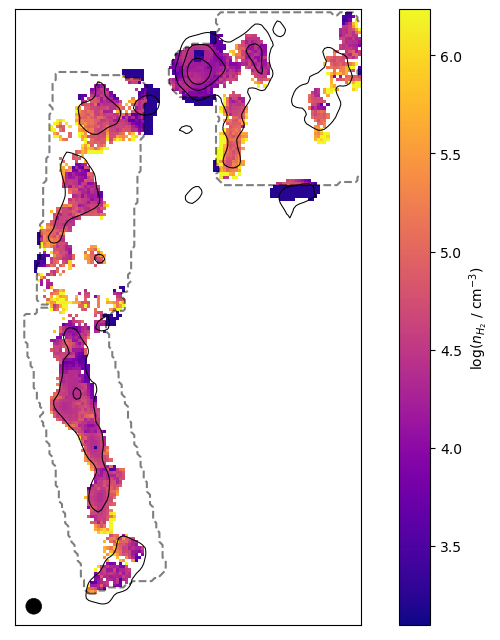

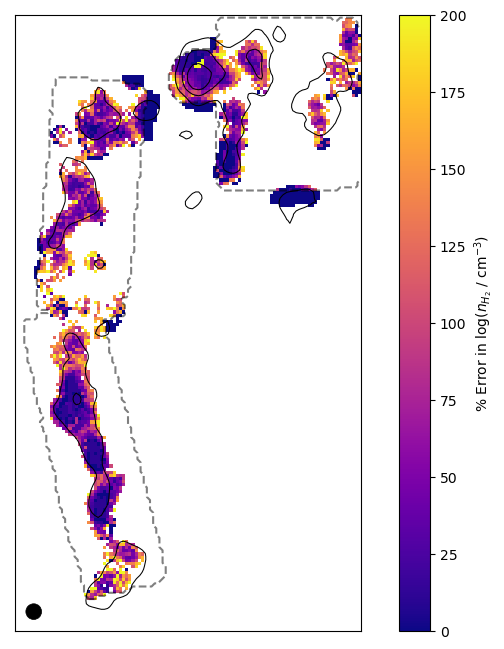

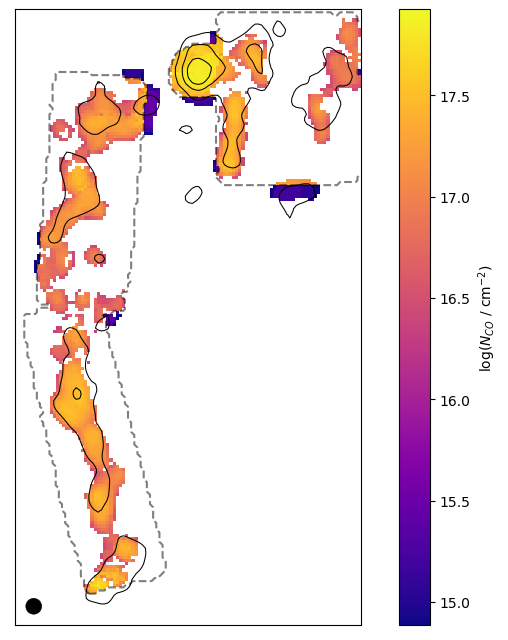

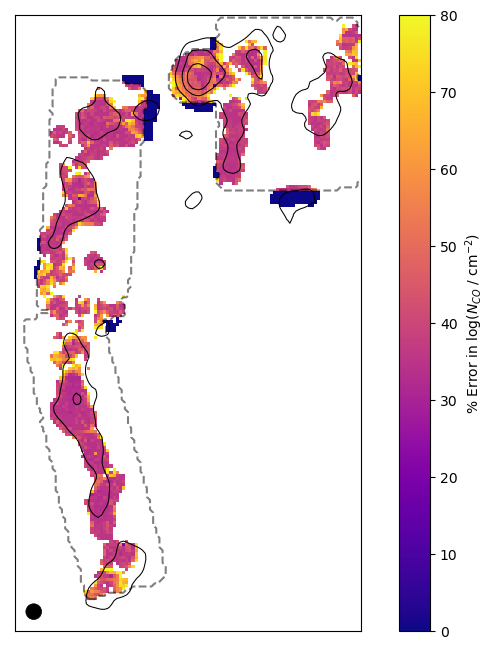

In [25]:
PlotFittedMaps(rfit.plotparams, resarrayFinal, ploterror=True, MapData=dat)